### CSYE 7105 - High Performance Parallel Machine Learning & AI

#### Final Project : 
### Parallel Deep Learning for Leukemia Classification from Blood Smear Images
### Done by Kaavya Loganathan & Ranjithnath Karunanidhi

#### Import Statements

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.distributed as dist
from torch.utils.data import Dataset, DataLoader, DistributedSampler, TensorDataset
from torch.optim import Adam
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

#### To check which GPU/CPU is being used

In [2]:
import torch
if torch.cuda.is_available():
    print("Current GPU:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    print("Total GPUs:", torch.cuda.device_count())
else:
    print("Running on CPU")

Current GPU: 0
Device name: Tesla V100-SXM2-16GB
Total GPUs: 4


In [3]:
# path to the train dataset
dataset_main = "/home/loganathan.k/leukemia/Team7_dataset/train/train"

In [4]:
# Standardize image size
image_size = 224
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Converts to [0, 1]
])

In [5]:
transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
)

In [6]:
# Clean class list to skip hidden/system folders
classes = sorted([
    d for d in os.listdir(dataset_main)
    if os.path.isdir(os.path.join(dataset_main, d)) and not d.startswith(".")
])

In [7]:
class_to_idx = {cls: i for i, cls in enumerate(classes)}
print("Class mapping:", class_to_idx)

Class mapping: {'all train': 0, 'aml train': 1, 'cll train': 2, 'cml': 3, 'h train': 4}


In [8]:
classes

['all train', 'aml train', 'cll train', 'cml', 'h train']

In [9]:
class_to_idx

{'all train': 0, 'aml train': 1, 'cll train': 2, 'cml': 3, 'h train': 4}

In [10]:
# There are 5 classes in the dataset namely : all, aml, cll, cml, h (healthy)

In [11]:
# Out of 5, 4 classes are classification of leukemia disease, last one is healthy

In [12]:
X_data, y_data = [], []

for cls in classes:
    cls_path = os.path.join(dataset_main, cls)

    subfolders = [f for f in os.listdir(cls_path) if os.path.isdir(os.path.join(cls_path, f))]
    if len(subfolders) == 1:
        cls_path = os.path.join(cls_path, subfolders[0])

    for img_name in tqdm(os.listdir(cls_path), desc=f"Processing {cls}"):
        img_path = os.path.join(cls_path, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img)
            X_data.append(img_tensor.numpy())
            y_data.append(class_to_idx[cls])
        except Exception as e:
            print(f"Skipping {img_name} due to error: {e}")

# Only after loop ends:
X_data = np.array(X_data)
y_data = np.array(y_data)

print(f"Done! Processed {len(X_data)} images.")
print(f"X_data shape: {X_data.shape}, y_data shape: {y_data.shape}")
print("Unique labels:", np.unique(y_data))

Processing h train: 100%|██████████| 3000/3000 [07:19<00:00,  6.82it/s]


Done! Processed 15000 images.
X_data shape: (15000, 3, 224, 224), y_data shape: (15000,)
Unique labels: [0 1 2 3 4]


In [ ]:
# Save
save_dir = "/home/loganathan.k/leukemia/Team7_dataset/train/processed"
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, "X_train.npy"), X_data)
np.save(os.path.join(save_dir, "y_train.npy"), y_data)

#### EDA and Visualization

In [12]:
class LeukemiaDataset(Dataset):
    def __init__(self, data_path, label_path, transform=None):
        self.data = np.load(data_path)
        self.labels = np.load(label_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = torch.tensor(self.data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

In [13]:
# File paths
X_path = "/home/loganathan.k/leukemia/Team7_dataset/train/processed/X_train.npy"
y_path = "/home/loganathan.k/leukemia/Team7_dataset/train/processed/y_train.npy"

In [14]:
# Create dataset and dataloader
dataset = LeukemiaDataset(X_path, y_path)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

In [15]:
class LeukemiaDataset(Dataset):
    def __init__(self, data_path, label_path, transform=None):
        self.data = np.load(data_path)
        self.labels = np.load(label_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        image = torch.tensor(image, dtype=torch.float32)

        # If image is grayscale (1 channel), convert to 3 channel
        if image.ndim == 3 and image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        if self.transform:
            image = self.transform(image)

        return image, int(label)

In [16]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize as 3 channels
])

BATCH_SIZE = 64
NUM_CLASSES = 5
# Create dataset instance
dataset = LeukemiaDataset(X_path, y_path, transform=transform)

In [17]:
def show_one_per_class(dataset, class_names=["ALL", "AML", "CLL", "CML", "Healthy"]):
    seen = set()
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))

    for idx in range(len(dataset)):
        image, label = dataset[idx]
        if label not in seen:
            ax = axs[len(seen)]
            img = image.permute(1, 2, 0).numpy()
            img = (img * 0.5 + 0.5).clip(0, 1)
            ax.imshow(img)
            ax.set_title(f"{class_names[label]}")
            ax.axis("off")
            seen.add(label)
        if len(seen) == 5:
            break

    plt.tight_layout()
    plt.show()


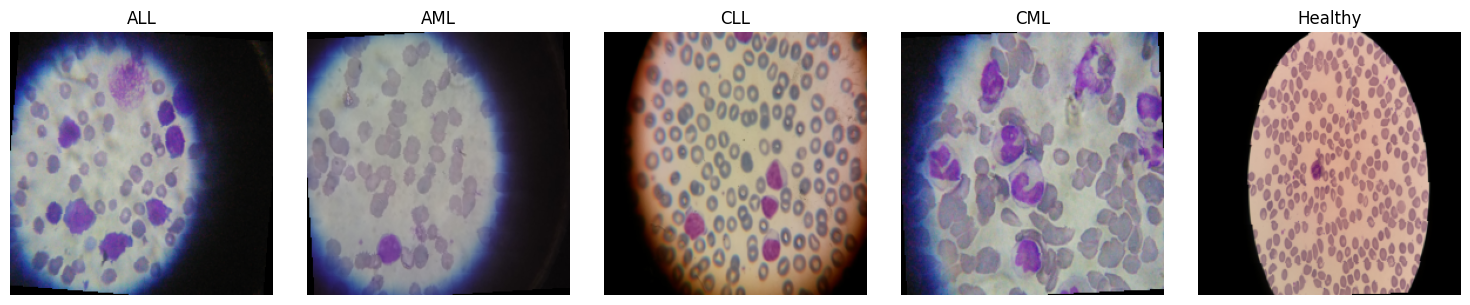

In [18]:
show_one_per_class(dataset)

In [19]:
def show_multiple_per_class(dataset, samples_per_class=4, class_names=["ALL", "AML", "CLL", "CML", "Healthy"]):
    from collections import defaultdict
    class_counts = defaultdict(int)
    fig, axs = plt.subplots(len(class_names), samples_per_class, figsize=(samples_per_class * 3, len(class_names) * 3))

    found = set()
    for image, label in dataset:
        if class_counts[label] < samples_per_class:
            row = label
            col = class_counts[label]
            img = image.permute(1, 2, 0).numpy()
            img = (img * 0.5 + 0.5).clip(0, 1)
            axs[row, col].imshow(img)
            axs[row, col].axis("off")
            if col == 0:
                axs[row, col].set_title(class_names[label], fontsize=12, loc="left")
            class_counts[label] += 1
        if all(class_counts[i] >= samples_per_class for i in range(len(class_names))):
            break

    plt.tight_layout()
    plt.show()


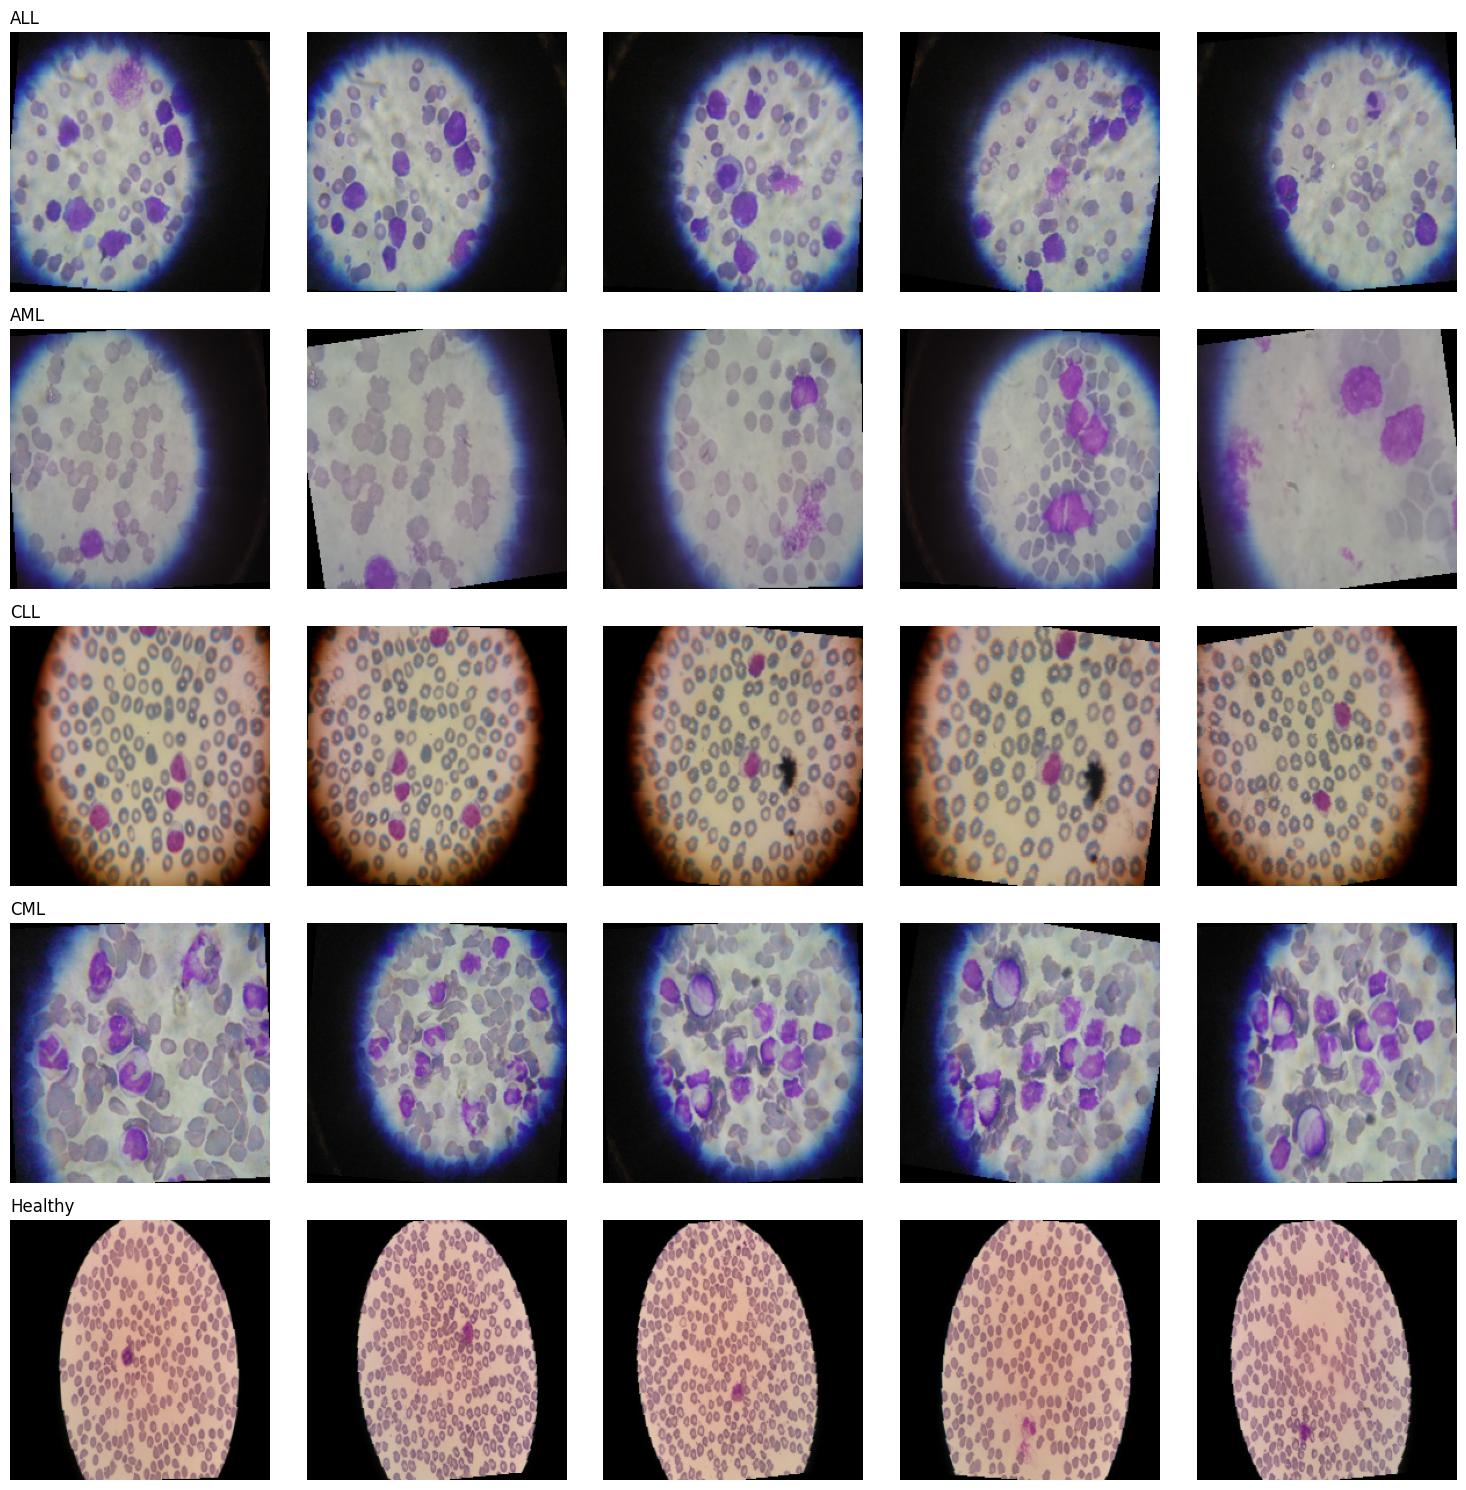

In [20]:
show_multiple_per_class(dataset, samples_per_class=5) 

#### Model training

#### We have used ddp, ddp+amp, fsdp and fsdp+amp in 2 different GPU types 
#### v100-sxm2 and a100 with 1, 2, 3 and 4 GPUs

##### Please go through the attached .py files namely,
##### train_ddp.py, train_ddp_amp.py, train_fsdp.py, train_fsdp_amp.py

##### we have used below commands in the terminal to run the .py files,

#### For each command on each GPU, we are storing a log file (eg: fsdp_amp_4gpu_a100.log) and in the .py files, we are storing the performance values in a .csv files.
#### We are also saving all the models, so that after finalizing the best performing model, we will work on that with our test data

#### All those stored in separate folders, for better understanding and cleanliness

#### Visualization with the performances

#### Plotting for V100-SXM2 - DDP - 1,2,3,4 GPUs

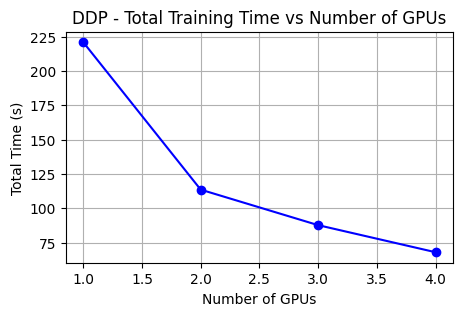

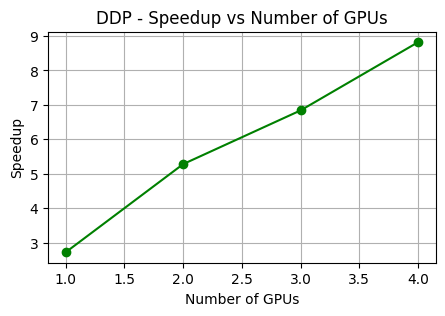

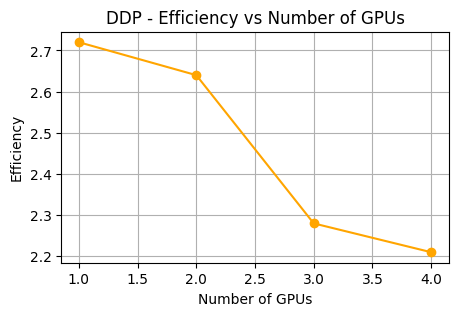

In [21]:
# Load DDP results from CSV
ddp_df = pd.read_csv("csv_files/ddp_gpu_results_v100-sxm2.csv")

# Filter for DDP only 
ddp_only = ddp_df[ddp_df["Parallelism"] == "DDP"]

# Convert to numeric 
ddp_only["TotalTime(s)"] = pd.to_numeric(ddp_only["TotalTime(s)"], errors="coerce")
ddp_only["Speedup"] = pd.to_numeric(ddp_only["Speedup"], errors="coerce")
ddp_only["Efficiency"] = pd.to_numeric(ddp_only["Efficiency"], errors="coerce")
ddp_only["NumGPUs"] = pd.to_numeric(ddp_only["NumGPUs"], errors="coerce")

# Sort by NumGPUs 
ddp_only = ddp_only.sort_values("NumGPUs")

# Total Training Time vs Number of GPUs
plt.figure(figsize=(5, 3))
plt.plot(ddp_only["NumGPUs"], ddp_only["TotalTime(s)"], marker='o', color='blue')
plt.title("DDP - Total Training Time vs Number of GPUs")
plt.xlabel("Number of GPUs")
plt.ylabel("Total Time (s)")
plt.grid(True)
plt.show()

# Speedup vs Number of GPUs
plt.figure(figsize=(5, 3))
plt.plot(ddp_only["NumGPUs"], ddp_only["Speedup"], marker='o', color='green')
plt.title("DDP - Speedup vs Number of GPUs")
plt.xlabel("Number of GPUs")
plt.ylabel("Speedup")
plt.grid(True)
plt.show()

# Efficiency vs Number of GPUs
plt.figure(figsize=(5, 3))
plt.plot(ddp_only["NumGPUs"], ddp_only["Efficiency"], marker='o', color='orange')
plt.title("DDP - Efficiency vs Number of GPUs")
plt.xlabel("Number of GPUs")
plt.ylabel("Efficiency")
plt.grid(True)
plt.show()


#### Plotting for V100-SXM2 - DDP+AMP - 1,2,3,4 GPUs

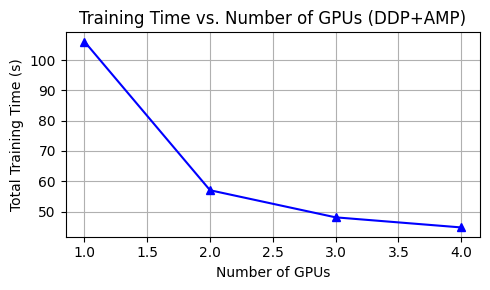

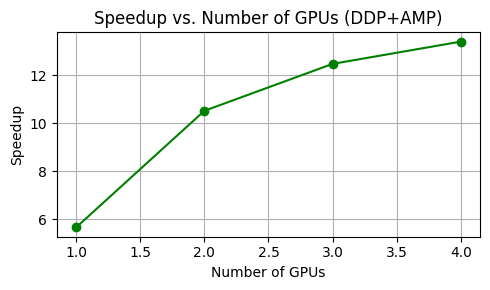

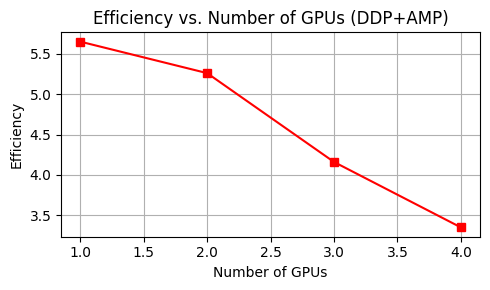

In [22]:
# Load the CSV file
df = pd.read_csv("csv_files/ddp_amp_gpu_results_v100-sxm2.csv")

# Filter for only DDP+AMP entries 
df_amp = df[df["Parallelism"] == "DDP+AMP"]

# Sort by number of GPUs
df_amp = df_amp.sort_values("NumGPUs")

# Extract values
gpus = df_amp["NumGPUs"].tolist()
time = df_amp["TotalTime(s)"].tolist()
speedup = df_amp["Speedup"].tolist()
efficiency = df_amp["Efficiency"].tolist()

# Training Time vs Number of GPUs
plt.figure(figsize=(5, 3))
plt.plot(gpus, time, marker='^', color='blue')
plt.title("Training Time vs. Number of GPUs (DDP+AMP)")
plt.xlabel("Number of GPUs")
plt.ylabel("Total Training Time (s)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Speedup vs Number of GPUs
plt.figure(figsize=(5, 3))
plt.plot(gpus, speedup, marker='o', color='green')
plt.title("Speedup vs. Number of GPUs (DDP+AMP)")
plt.xlabel("Number of GPUs")
plt.ylabel("Speedup")
plt.grid(True)
plt.tight_layout()
plt.show()

# Efficiency vs Number of GPUs
plt.figure(figsize=(5, 3))
plt.plot(gpus, efficiency, marker='s', color='red')
plt.title("Efficiency vs. Number of GPUs (DDP+AMP)")
plt.xlabel("Number of GPUs")
plt.ylabel("Efficiency")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Comparison Plot: DDP vs DDP+AMP

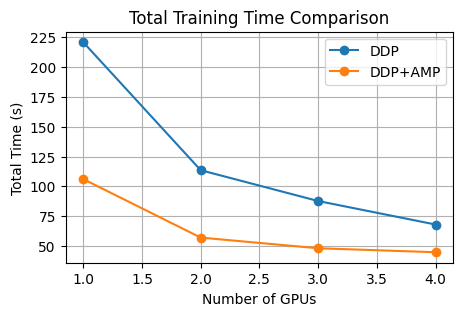

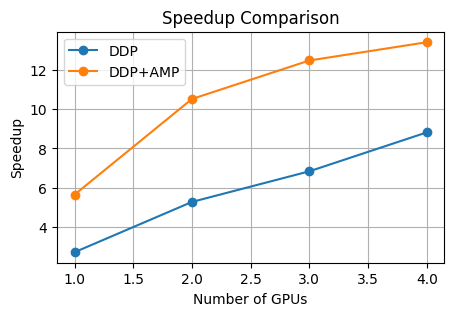

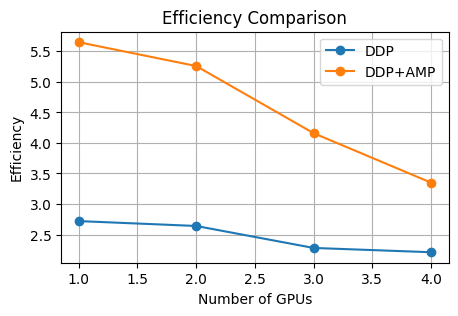

In [23]:
# Load both CSV files
ddp = pd.read_csv("csv_files/ddp_gpu_results_v100-sxm2.csv")
amp = pd.read_csv("csv_files/ddp_amp_gpu_results_v100-sxm2.csv")

# Convert necessary columns to numeric
for df in [ddp, amp]:
    df["NumGPUs"] = pd.to_numeric(df["NumGPUs"], errors="coerce")
    df["TotalTime(s)"] = pd.to_numeric(df["TotalTime(s)"], errors="coerce")
    df["Speedup"] = pd.to_numeric(df["Speedup"], errors="coerce")
    df["Efficiency"] = pd.to_numeric(df["Efficiency"], errors="coerce")

# Sort both for clean plots
ddp = ddp.sort_values("NumGPUs")
amp = amp.sort_values("NumGPUs")

# Total Time Comparison
plt.figure(figsize=(5, 3))
plt.plot(ddp["NumGPUs"], ddp["TotalTime(s)"], label="DDP", marker="o")
plt.plot(amp["NumGPUs"], amp["TotalTime(s)"], label="DDP+AMP", marker="o")
plt.title("Total Training Time Comparison")
plt.xlabel("Number of GPUs")
plt.ylabel("Total Time (s)")
plt.grid(True)
plt.legend()
plt.show()

# Speedup Comparison 
plt.figure(figsize=(5, 3))
plt.plot(ddp["NumGPUs"], ddp["Speedup"], label="DDP", marker="o")
plt.plot(amp["NumGPUs"], amp["Speedup"], label="DDP+AMP", marker="o")
plt.title("Speedup Comparison")
plt.xlabel("Number of GPUs")
plt.ylabel("Speedup")
plt.grid(True)
plt.legend()
plt.show()

# Efficiency Comparison 
plt.figure(figsize=(5, 3))
plt.plot(ddp["NumGPUs"], ddp["Efficiency"], label="DDP", marker="o")
plt.plot(amp["NumGPUs"], amp["Efficiency"], label="DDP+AMP", marker="o")
plt.title("Efficiency Comparison")
plt.xlabel("Number of GPUs")
plt.ylabel("Efficiency")
plt.grid(True)
plt.legend()
plt.show()


#### Plotting for V100-SXM2 - FSDP - 1,2,3,4 GPUs

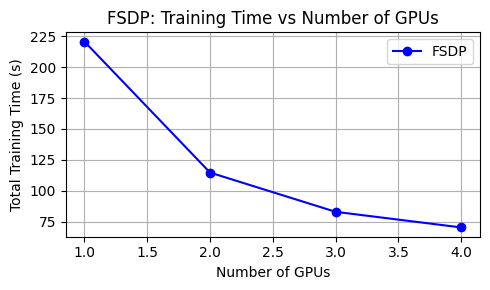

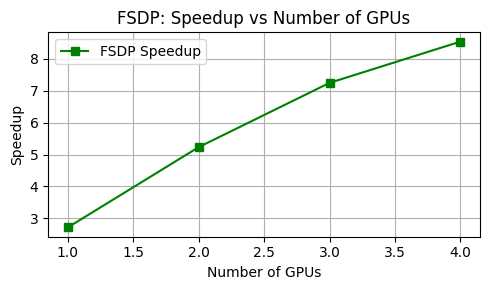

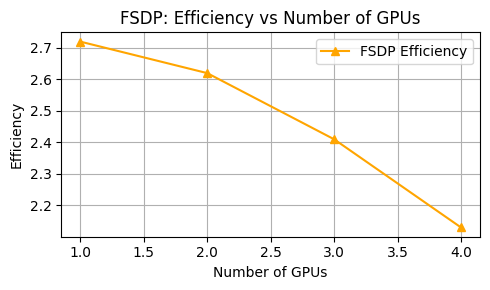

In [24]:
# Load FSDP-only CSV
fsdp = pd.read_csv("csv_files/fsdp_gpu_results_v100-sxm2.csv")

# Sort by number of GPUs
fsdp = fsdp.sort_values("NumGPUs")

# Extract values
gpus = fsdp["NumGPUs"]
total_time = fsdp["TotalTime(s)"]
speedup = fsdp["Speedup"]
efficiency = fsdp["Efficiency"]

# Total Training Time 
plt.figure(figsize=(5, 3))
plt.plot(gpus, total_time, marker="o", color='blue', label="FSDP")
plt.title("FSDP: Training Time vs Number of GPUs")
plt.xlabel("Number of GPUs")
plt.ylabel("Total Training Time (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Speedup 
plt.figure(figsize=(5, 3))
plt.plot(gpus, speedup, marker="s", color="green", label="FSDP Speedup")
plt.title("FSDP: Speedup vs Number of GPUs")
plt.xlabel("Number of GPUs")
plt.ylabel("Speedup")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Efficiency
plt.figure(figsize=(5, 3))
plt.plot(gpus, efficiency, marker="^", color="orange", label="FSDP Efficiency")
plt.title("FSDP: Efficiency vs Number of GPUs")
plt.xlabel("Number of GPUs")
plt.ylabel("Efficiency")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Plotting for V100-SXM2 - FSDP+AMP - 1,2,3,4 GPUs

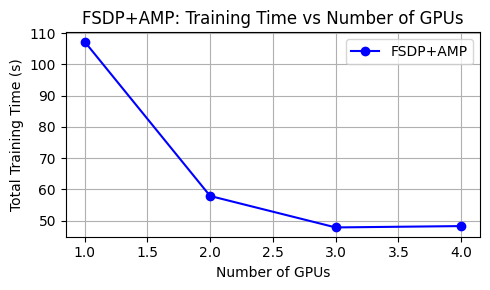

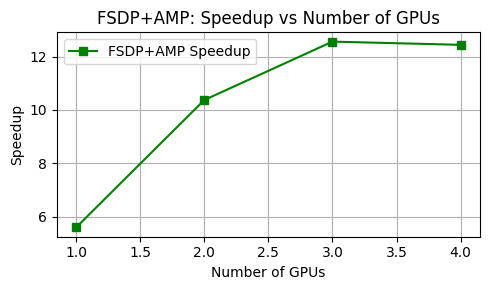

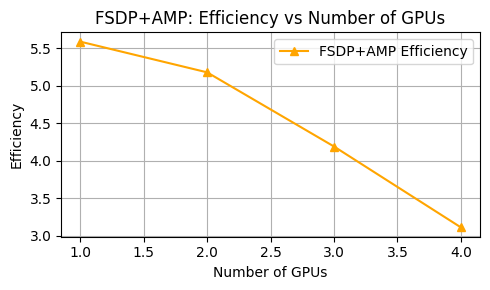

In [25]:
# Load FSDP+AMP results
fsdp_amp = pd.read_csv("csv_files/fsdp_amp_gpu_results_v100-sxm2.csv")

# Sort by GPU count
fsdp_amp = fsdp_amp.sort_values("NumGPUs")

# Extract columns
gpus = fsdp_amp["NumGPUs"]
total_time = fsdp_amp["TotalTime(s)"]
speedup = fsdp_amp["Speedup"]
efficiency = fsdp_amp["Efficiency"]

# Training Time vs Number of GPUs 
plt.figure(figsize=(5, 3))
plt.plot(gpus, total_time, marker="o", color="blue", label="FSDP+AMP")
plt.title("FSDP+AMP: Training Time vs Number of GPUs")
plt.xlabel("Number of GPUs")
plt.ylabel("Total Training Time (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Speedup vs Number of GPUs
plt.figure(figsize=(5, 3))
plt.plot(gpus, speedup, marker="s", color="green", label="FSDP+AMP Speedup")
plt.title("FSDP+AMP: Speedup vs Number of GPUs")
plt.xlabel("Number of GPUs")
plt.ylabel("Speedup")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Efficiency vs Number of GPUs
plt.figure(figsize=(5, 3))
plt.plot(gpus, efficiency, marker="^", color="orange", label="FSDP+AMP Efficiency")
plt.title("FSDP+AMP: Efficiency vs Number of GPUs")
plt.xlabel("Number of GPUs")
plt.ylabel("Efficiency")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Comparison - V100-SXM2 - FSDP vs FSDP+AMP - 1,2,3,4 GPUs

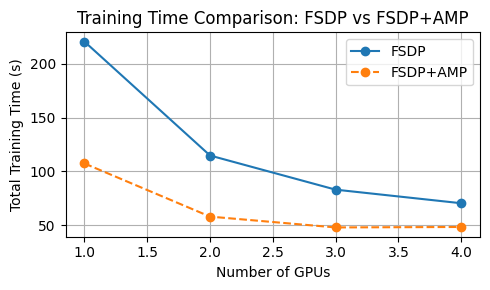

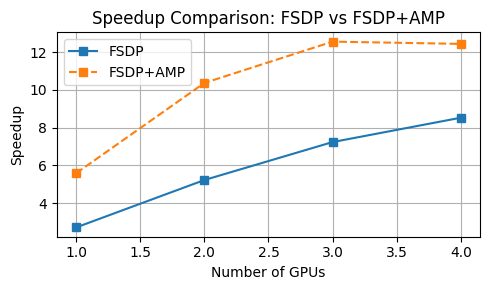

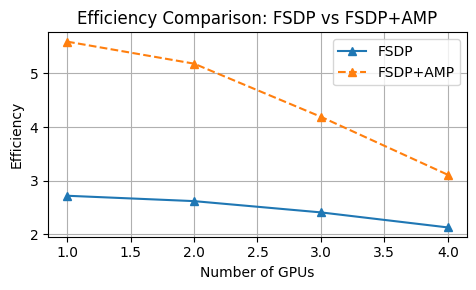

In [26]:
# Load both CSVs
fsdp = pd.read_csv("csv_files/fsdp_gpu_results_v100-sxm2.csv")
fsdp_amp = pd.read_csv("csv_files/fsdp_amp_gpu_results_v100-sxm2.csv")

# Sort by number of GPUs
fsdp = fsdp.sort_values("NumGPUs")
fsdp_amp = fsdp_amp.sort_values("NumGPUs")

# X-axis: Number of GPUs
gpus = fsdp["NumGPUs"]

# Total Training Time 
plt.figure(figsize=(5, 3))
plt.plot(gpus, fsdp["TotalTime(s)"], marker="o", label="FSDP")
plt.plot(gpus, fsdp_amp["TotalTime(s)"], marker="o", linestyle="--", label="FSDP+AMP")
plt.title("Training Time Comparison: FSDP vs FSDP+AMP")
plt.xlabel("Number of GPUs")
plt.ylabel("Total Training Time (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Speedup Comparison 
plt.figure(figsize=(5, 3))
plt.plot(gpus, fsdp["Speedup"], marker="s", label="FSDP")
plt.plot(gpus, fsdp_amp["Speedup"], marker="s", linestyle="--", label="FSDP+AMP")
plt.title("Speedup Comparison: FSDP vs FSDP+AMP")
plt.xlabel("Number of GPUs")
plt.ylabel("Speedup")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Efficiency Comparison
plt.figure(figsize=(5, 3))
plt.plot(gpus, fsdp["Efficiency"], marker="^", label="FSDP")
plt.plot(gpus, fsdp_amp["Efficiency"], marker="^", linestyle="--", label="FSDP+AMP")
plt.title("Efficiency Comparison: FSDP vs FSDP+AMP")
plt.xlabel("Number of GPUs")
plt.ylabel("Efficiency")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Plotting with the performance data with A100 GPU

In [2]:
import torch
if torch.cuda.is_available():
    print("Current GPU:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    print("Total GPUs:", torch.cuda.device_count())
else:
    print("Running on CPU")

Current GPU: 0
Device name: NVIDIA A100-SXM4-40GB
Total GPUs: 8


#### Plotting for A100 - DDP - 1,2,3,4 GPUs

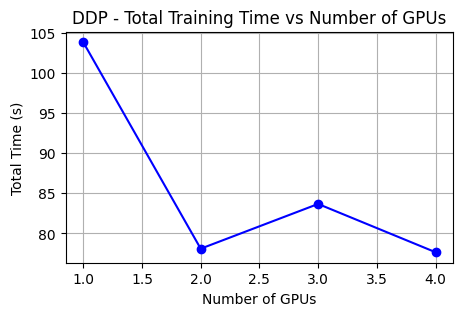

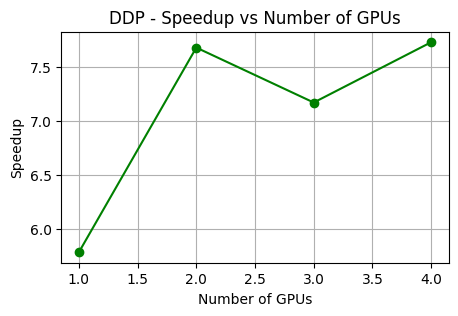

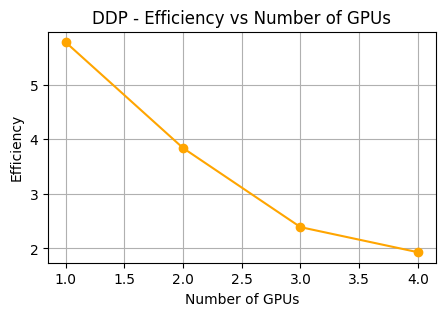

In [27]:
# Load DDP results from CSV
ddp_df = pd.read_csv("csv_files/ddp_gpu_results_a100.csv")

# Filter for DDP only 
ddp_only = ddp_df[ddp_df["Parallelism"] == "DDP"]

# Convert to numeric 
ddp_only["TotalTime(s)"] = pd.to_numeric(ddp_only["TotalTime(s)"], errors="coerce")
ddp_only["Speedup"] = pd.to_numeric(ddp_only["Speedup"], errors="coerce")
ddp_only["Efficiency"] = pd.to_numeric(ddp_only["Efficiency"], errors="coerce")
ddp_only["NumGPUs"] = pd.to_numeric(ddp_only["NumGPUs"], errors="coerce")

# Sort by NumGPUs for clean plotting
ddp_only = ddp_only.sort_values("NumGPUs")

# Total Training Time vs Number of GPUs
plt.figure(figsize=(5, 3))
plt.plot(ddp_only["NumGPUs"], ddp_only["TotalTime(s)"], marker='o', color='blue')
plt.title("DDP - Total Training Time vs Number of GPUs")
plt.xlabel("Number of GPUs")
plt.ylabel("Total Time (s)")
plt.grid(True)
plt.show()

# Speedup vs Number of GPUs
plt.figure(figsize=(5, 3))
plt.plot(ddp_only["NumGPUs"], ddp_only["Speedup"], marker='o', color='green')
plt.title("DDP - Speedup vs Number of GPUs")
plt.xlabel("Number of GPUs")
plt.ylabel("Speedup")
plt.grid(True)
plt.show()

# Efficiency vs Number of GPUs
plt.figure(figsize=(5, 3))
plt.plot(ddp_only["NumGPUs"], ddp_only["Efficiency"], marker='o', color='orange')
plt.title("DDP - Efficiency vs Number of GPUs")
plt.xlabel("Number of GPUs")
plt.ylabel("Efficiency")
plt.grid(True)
plt.show()


#### Plotting for A100 - DDP+AMP - 1,2,3,4 GPUs

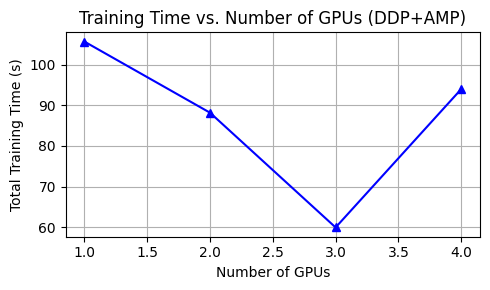

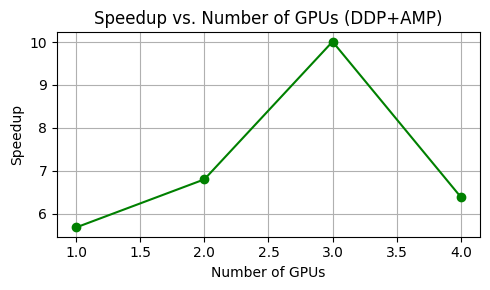

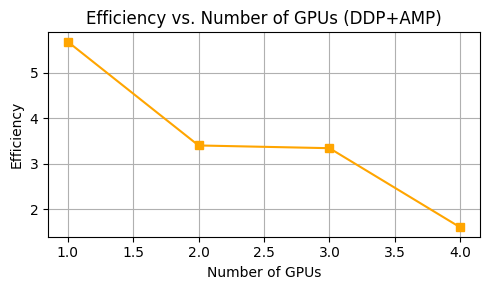

In [28]:
# Load the CSV file
df = pd.read_csv("csv_files/ddp_amp_gpu_results_a100.csv")

# Filter for only DDP+AMP entries 
df_amp = df[df["Parallelism"] == "DDP+AMP"]

# Sort by number of GPUs 
df_amp = df_amp.sort_values("NumGPUs")

# Extract values
gpus = df_amp["NumGPUs"].tolist()
time = df_amp["TotalTime(s)"].tolist()
speedup = df_amp["Speedup"].tolist()
efficiency = df_amp["Efficiency"].tolist()

# Plot: Training Time vs Number of GPUs
plt.figure(figsize=(5, 3))
plt.plot(gpus, time, marker='^', color='blue')
plt.title("Training Time vs. Number of GPUs (DDP+AMP)")
plt.xlabel("Number of GPUs")
plt.ylabel("Total Training Time (s)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Speedup vs Number of GPUs
plt.figure(figsize=(5, 3))
plt.plot(gpus, speedup, marker='o', color='green')
plt.title("Speedup vs. Number of GPUs (DDP+AMP)")
plt.xlabel("Number of GPUs")
plt.ylabel("Speedup")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Efficiency vs Number of GPUs
plt.figure(figsize=(5, 3))
plt.plot(gpus, efficiency, marker='s', color='orange')
plt.title("Efficiency vs. Number of GPUs (DDP+AMP)")
plt.xlabel("Number of GPUs")
plt.ylabel("Efficiency")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Comparison - A100 - DDP vs DDP+AMP - 1,2,3,4 GPUs

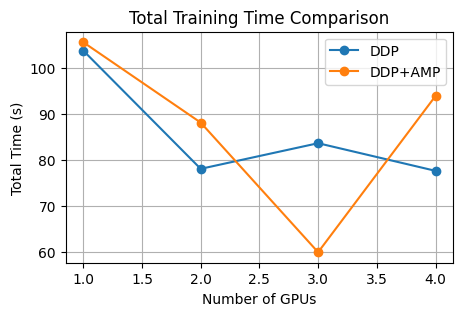

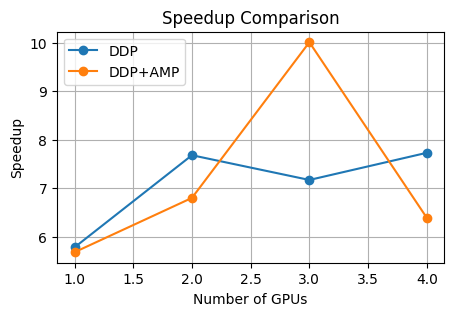

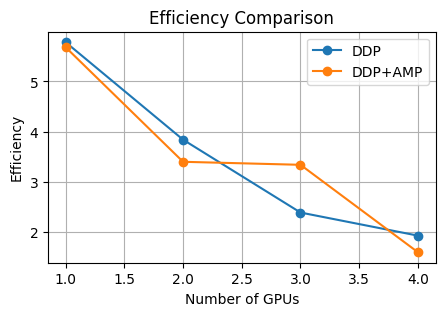

In [29]:
# Load both CSV files
ddp = pd.read_csv("csv_files/ddp_gpu_results_a100.csv")
amp = pd.read_csv("csv_files/ddp_amp_gpu_results_a100.csv")

# Convert necessary columns to numeric
for df in [ddp, amp]:
    df["NumGPUs"] = pd.to_numeric(df["NumGPUs"], errors="coerce")
    df["TotalTime(s)"] = pd.to_numeric(df["TotalTime(s)"], errors="coerce")
    df["Speedup"] = pd.to_numeric(df["Speedup"], errors="coerce")
    df["Efficiency"] = pd.to_numeric(df["Efficiency"], errors="coerce")

# Sort both for clean plots
ddp = ddp.sort_values("NumGPUs")
amp = amp.sort_values("NumGPUs")

# Total Time Comparison
plt.figure(figsize=(5, 3))
plt.plot(ddp["NumGPUs"], ddp["TotalTime(s)"], label="DDP", marker="o")
plt.plot(amp["NumGPUs"], amp["TotalTime(s)"], label="DDP+AMP", marker="o")
plt.title("Total Training Time Comparison")
plt.xlabel("Number of GPUs")
plt.ylabel("Total Time (s)")
plt.grid(True)
plt.legend()
plt.show()

# Speedup Comparison 
plt.figure(figsize=(5, 3))
plt.plot(ddp["NumGPUs"], ddp["Speedup"], label="DDP", marker="o")
plt.plot(amp["NumGPUs"], amp["Speedup"], label="DDP+AMP", marker="o")
plt.title("Speedup Comparison")
plt.xlabel("Number of GPUs")
plt.ylabel("Speedup")
plt.grid(True)
plt.legend()
plt.show()

# Efficiency Comparison 
plt.figure(figsize=(5, 3))
plt.plot(ddp["NumGPUs"], ddp["Efficiency"], label="DDP", marker="o")
plt.plot(amp["NumGPUs"], amp["Efficiency"], label="DDP+AMP", marker="o")
plt.title("Efficiency Comparison")
plt.xlabel("Number of GPUs")
plt.ylabel("Efficiency")
plt.grid(True)
plt.legend()
plt.show()

#### Plotting for A100 - FSDP - 1,2,3,4 GPUs

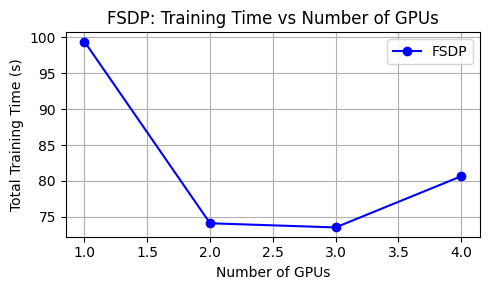

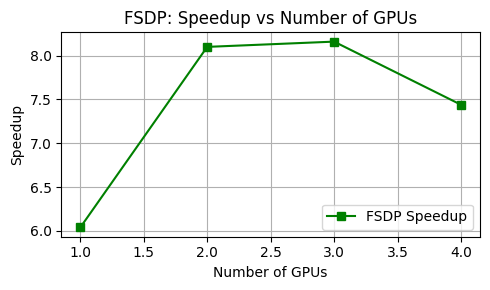

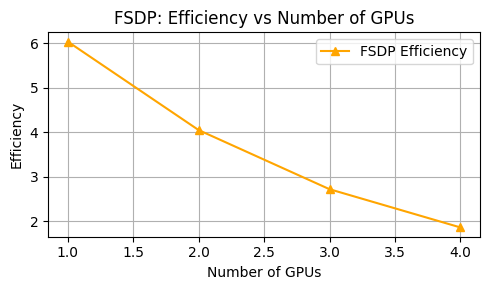

In [30]:
# Load FSDP-only CSV
fsdp = pd.read_csv("csv_files/fsdp_gpu_results_a100.csv")

# Sort by number of GPUs 
fsdp = fsdp.sort_values("NumGPUs")

# Extract values
gpus = fsdp["NumGPUs"]
total_time = fsdp["TotalTime(s)"]
speedup = fsdp["Speedup"]
efficiency = fsdp["Efficiency"]

# Total Training Time 
plt.figure(figsize=(5, 3))
plt.plot(gpus, total_time, marker="o", color='blue', label="FSDP")
plt.title("FSDP: Training Time vs Number of GPUs")
plt.xlabel("Number of GPUs")
plt.ylabel("Total Training Time (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Speedup 
plt.figure(figsize=(5, 3))
plt.plot(gpus, speedup, marker="s", color="green", label="FSDP Speedup")
plt.title("FSDP: Speedup vs Number of GPUs")
plt.xlabel("Number of GPUs")
plt.ylabel("Speedup")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Efficiency
plt.figure(figsize=(5, 3))
plt.plot(gpus, efficiency, marker="^", color="orange", label="FSDP Efficiency")
plt.title("FSDP: Efficiency vs Number of GPUs")
plt.xlabel("Number of GPUs")
plt.ylabel("Efficiency")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Plotting for A100 - FSDP+AMP - 1,2,3,4 GPUs

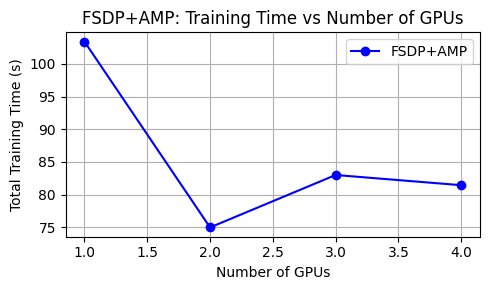

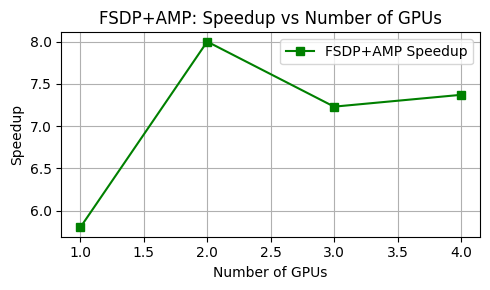

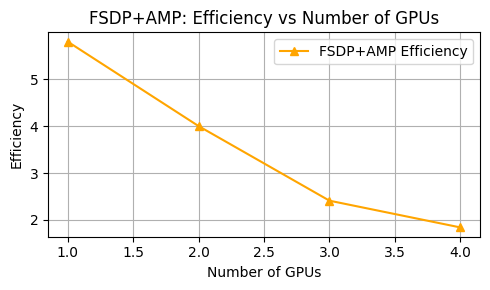

In [31]:
# Load FSDP+AMP results
fsdp_amp = pd.read_csv("csv_files/fsdp_amp_gpu_results_a100.csv")

# Sort by GPU count
fsdp_amp = fsdp_amp.sort_values("NumGPUs")

# Extract columns
gpus = fsdp_amp["NumGPUs"]
total_time = fsdp_amp["TotalTime(s)"]
speedup = fsdp_amp["Speedup"]
efficiency = fsdp_amp["Efficiency"]

# Training Time vs Number of GPUs 
plt.figure(figsize=(5, 3))
plt.plot(gpus, total_time, marker="o", color="blue", label="FSDP+AMP")
plt.title("FSDP+AMP: Training Time vs Number of GPUs")
plt.xlabel("Number of GPUs")
plt.ylabel("Total Training Time (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Speedup vs Number of GPUs
plt.figure(figsize=(5, 3))
plt.plot(gpus, speedup, marker="s", color="green", label="FSDP+AMP Speedup")
plt.title("FSDP+AMP: Speedup vs Number of GPUs")
plt.xlabel("Number of GPUs")
plt.ylabel("Speedup")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Efficiency vs Number of GPUs
plt.figure(figsize=(5, 3))
plt.plot(gpus, efficiency, marker="^", color="orange", label="FSDP+AMP Efficiency")
plt.title("FSDP+AMP: Efficiency vs Number of GPUs")
plt.xlabel("Number of GPUs")
plt.ylabel("Efficiency")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
#### Comparison - A100 - FSDP vs FSDP+AMP - 1,2,3,4 GPUs

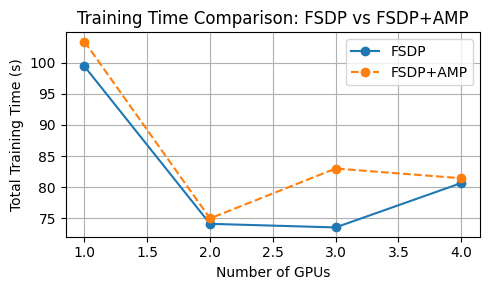

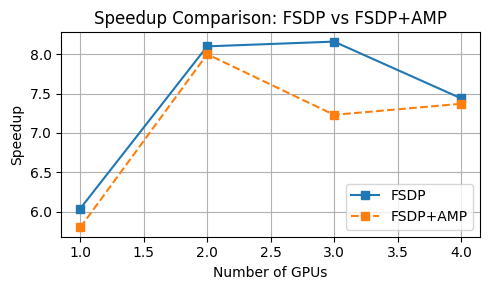

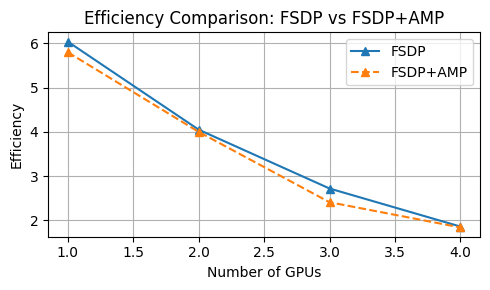

In [33]:
# Load both CSVs
fsdp = pd.read_csv("csv_files/fsdp_gpu_results_a100.csv")
fsdp_amp = pd.read_csv("csv_files/fsdp_amp_gpu_results_a100.csv")

# Sort by number of GPUs
fsdp = fsdp.sort_values("NumGPUs")
fsdp_amp = fsdp_amp.sort_values("NumGPUs")

# X-axis: Number of GPUs
gpus = fsdp["NumGPUs"]

# Total Training Time 
plt.figure(figsize=(5, 3))
plt.plot(gpus, fsdp["TotalTime(s)"], marker="o", label="FSDP")
plt.plot(gpus, fsdp_amp["TotalTime(s)"], marker="o", linestyle="--", label="FSDP+AMP")
plt.title("Training Time Comparison: FSDP vs FSDP+AMP")
plt.xlabel("Number of GPUs")
plt.ylabel("Total Training Time (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Speedup Comparison 
plt.figure(figsize=(5, 3))
plt.plot(gpus, fsdp["Speedup"], marker="s", label="FSDP")
plt.plot(gpus, fsdp_amp["Speedup"], marker="s", linestyle="--", label="FSDP+AMP")
plt.title("Speedup Comparison: FSDP vs FSDP+AMP")
plt.xlabel("Number of GPUs")
plt.ylabel("Speedup")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Efficiency Comparison
plt.figure(figsize=(5, 3))
plt.plot(gpus, fsdp["Efficiency"], marker="^", label="FSDP")
plt.plot(gpus, fsdp_amp["Efficiency"], marker="^", linestyle="--", label="FSDP+AMP")
plt.title("Efficiency Comparison: FSDP vs FSDP+AMP")
plt.xlabel("Number of GPUs")
plt.ylabel("Efficiency")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Comparison for V100-SXM2 - DDP+AMP vs A100 - DDP+AMP - 1,2,3,4 GPUs

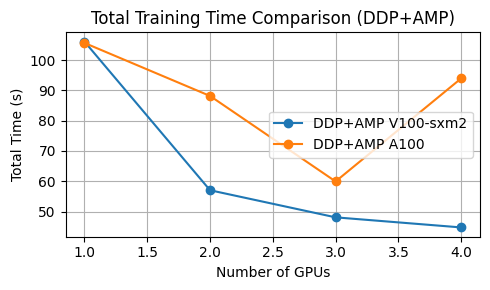

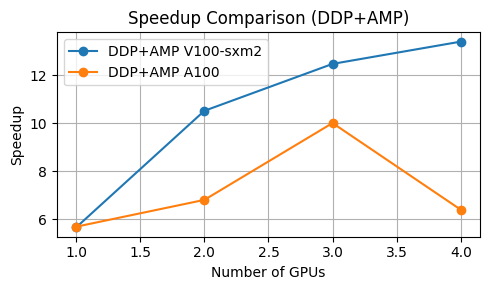

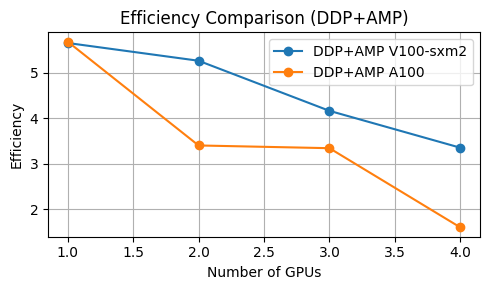

In [34]:
# Load CSV files
v100 = pd.read_csv("csv_files/ddp_amp_gpu_results_v100-sxm2.csv")
a100 = pd.read_csv("csv_files/ddp_amp_gpu_results_a100.csv")

# Convert necessary columns
for df in [v100, a100]:
    df["NumGPUs"] = pd.to_numeric(df["NumGPUs"], errors="coerce")
    df["TotalTime(s)"] = pd.to_numeric(df["TotalTime(s)"], errors="coerce")
    df["Speedup"] = pd.to_numeric(df["Speedup"], errors="coerce")
    df["Efficiency"] = pd.to_numeric(df["Efficiency"], errors="coerce")

# Sort for clean plotting
v100 = v100.sort_values("NumGPUs")
a100 = a100.sort_values("NumGPUs")

# Total Training Time Plot
plt.figure(figsize=(5, 3))
plt.plot(v100["NumGPUs"], v100["TotalTime(s)"], label="DDP+AMP V100-sxm2", marker="o")
plt.plot(a100["NumGPUs"], a100["TotalTime(s)"], label="DDP+AMP A100", marker="o")
plt.title("Total Training Time Comparison (DDP+AMP)")
plt.xlabel("Number of GPUs")
plt.ylabel("Total Time (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Speedup Plot
plt.figure(figsize=(5, 3))
plt.plot(v100["NumGPUs"], v100["Speedup"], label="DDP+AMP V100-sxm2", marker="o")
plt.plot(a100["NumGPUs"], a100["Speedup"], label="DDP+AMP A100", marker="o")
plt.title("Speedup Comparison (DDP+AMP)")
plt.xlabel("Number of GPUs")
plt.ylabel("Speedup")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Efficiency Plot
plt.figure(figsize=(5, 3))
plt.plot(v100["NumGPUs"], v100["Efficiency"], label="DDP+AMP V100-sxm2", marker="o")
plt.plot(a100["NumGPUs"], a100["Efficiency"], label="DDP+AMP A100", marker="o")
plt.title("Efficiency Comparison (DDP+AMP)")
plt.xlabel("Number of GPUs")
plt.ylabel("Efficiency")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### From the data and graphs, we could learn that DDP+AMP in V100-SXM2 GPU performs well. To finalize, below is the graph that shows that, the model has the best performance with training time.

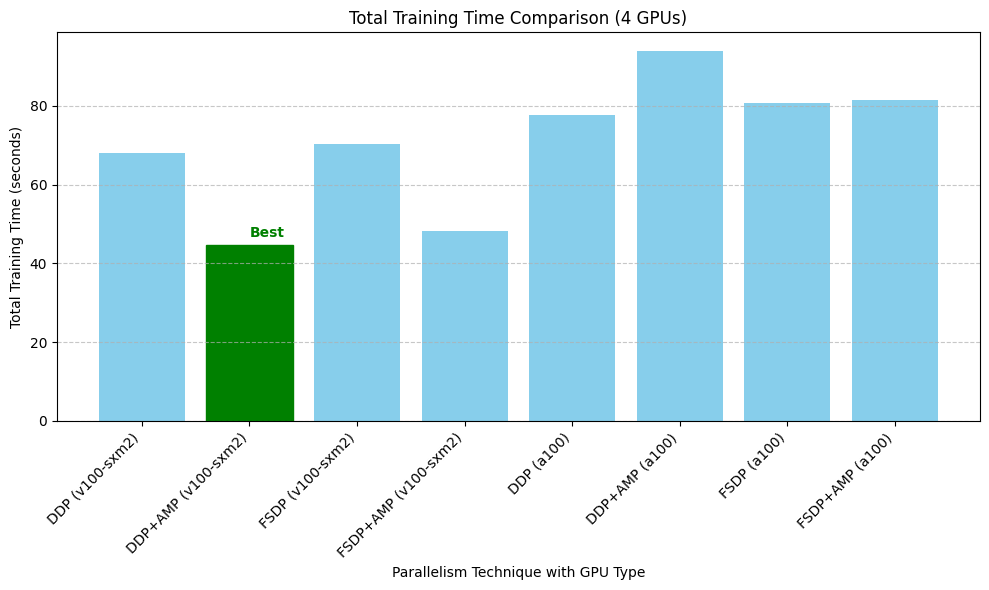

In [35]:
# Define file paths
csv_files = {
    "DDP (v100-sxm2)": "csv_files/ddp_gpu_results_v100-sxm2.csv",
    "DDP+AMP (v100-sxm2)": "csv_files/ddp_amp_gpu_results_v100-sxm2.csv",
    "FSDP (v100-sxm2)": "csv_files/fsdp_gpu_results_v100-sxm2.csv",
    "FSDP+AMP (v100-sxm2)": "csv_files/fsdp_amp_gpu_results_v100-sxm2.csv",
    "DDP (a100)": "csv_files/ddp_gpu_results_a100.csv",
    "DDP+AMP (a100)": "csv_files/ddp_amp_gpu_results_a100.csv",
    "FSDP (a100)": "csv_files/fsdp_gpu_results_a100.csv",
    "FSDP+AMP (a100)": "csv_files/fsdp_amp_gpu_results_a100.csv"
}

labels = []
times = []

# Read from all files
for label, path in csv_files.items():
    df = pd.read_csv(path)
    df["NumGPUs"] = pd.to_numeric(df["NumGPUs"], errors='coerce')
    df["TotalTime(s)"] = pd.to_numeric(df["TotalTime(s)"], errors='coerce')
    
    time_4gpu = df[df["NumGPUs"] == 4]["TotalTime(s)"].values[0]
    
    labels.append(label)
    times.append(time_4gpu)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, times, color='skyblue')

# Highlight best time
best_index = times.index(min(times))
bars[best_index].set_color('green')

plt.xticks(rotation=45, ha='right')
plt.xlabel("Parallelism Technique with GPU Type")
plt.ylabel("Total Training Time (seconds)")
plt.title("Total Training Time Comparison (4 GPUs)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate best bar
plt.text(best_index, times[best_index] + 2, "Best", color='green', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


### To summarize,

### DDP + AMP model with v100-sxm2 is the best model for this project

#### Evaluate the best model with the Test data

In [46]:
# List of full class subdirectories
class_dirs = {
    "all test": "/home/loganathan.k/leukemia/Team7_dataset/test/test/ALL TEST-20230225T082325Z-001/ALL TEST",
    "aml test": "/home/loganathan.k/leukemia/Team7_dataset/test/test/AML TEST-20230225T082630Z-001/AML TEST",
    "cll test": "/home/loganathan.k/leukemia/Team7_dataset/test/test/CLL TEST-20230225T082851Z-001/CLL TEST",
    "cml test": "/home/loganathan.k/leukemia/Team7_dataset/test/test/CML TEST-20230225T083148Z-001/CML TEST",
    "h test": "/home/loganathan.k/leukemia/Team7_dataset/test/test/H TEST-20230225T083612Z-001/H TEST",
}

save_dir = "/home/loganathan.k/leukemia/Team7_dataset/test/processed"
os.makedirs(save_dir, exist_ok=True)

# Image transformation
image_size = 224
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# Map classes
classes = sorted(class_dirs.keys())
class_to_idx = {cls: i for i, cls in enumerate(classes)}
print("Class mapping:", class_to_idx)

# Load and process images
X_test, y_test = [], []

for cls, path in class_dirs.items():
    for img_name in tqdm(os.listdir(path), desc=f"Processing {cls}"):
        img_path = os.path.join(path, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img)
            X_test.append(img_tensor.numpy())
            y_test.append(class_to_idx[cls])
        except Exception as e:
            print(f"Skipping {img_name} due to error: {e}")

# Save as NumPy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
np.save(os.path.join(save_dir, "X_test.npy"), X_test)
np.save(os.path.join(save_dir, "y_test.npy"), y_test)

print(f"Saved {len(X_test)} test samples to: {save_dir}")


Class mapping: {'all test': 0, 'aml test': 1, 'cll test': 2, 'cml test': 3, 'h test': 4}


Processing h test: 100%|██████████| 1000/1000 [02:04<00:00,  8.03it/s]


Saved 5000 test samples to: /home/loganathan.k/leukemia/Team7_dataset/test/processed


In [36]:
class LeukemiaTestDataset(Dataset):
    def __init__(self, data_path, label_path):
        self.data = np.load(data_path)
        self.labels = np.load(label_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = torch.tensor(self.data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

X_test_path = "/home/loganathan.k/leukemia/Team7_dataset/test/processed/X_test.npy"
y_test_path = "/home/loganathan.k/leukemia/Team7_dataset/test/processed/y_test.npy"

test_dataset = LeukemiaTestDataset(X_test_path, y_test_path)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [37]:
data = np.load("training_metrics/v100-sxm2_metrics_ddp_amp_4gpu.npz")

print("Keys inside npz file:", data.files)

print("Loss per epoch:", data['losses'])
print("Accuracy per epoch:", data['accuracies'])
print("Epoch time per epoch:", data['epoch_times'])

# GPU Utilization 
if 'gpu_utils' in data.files:
    print("GPU Utilization per epoch:", data['gpu_utils'])


Keys inside npz file: ['losses', 'accuracies', 'epoch_times', 'gpu_utils']
Loss per epoch: [25.55706205  1.78397399  0.68096164  0.36028545  0.28365859]
Accuracy per epoch: [0.87493333 0.9912     0.99626667 0.99893333 0.9992    ]
Epoch time per epoch: [10.5373106   8.82307863  8.47065568  8.5379765   8.38615441]
GPU Utilization per epoch: [[[   72  4649 16384]
  [   49  4649 16384]
  [   30  4633 16384]
  [   36  4601 16384]]

 [[   76  4649 16384]
  [   12  4649 16384]
  [   52  4633 16384]
  [   32  4601 16384]]

 [[    0  4649 16384]
  [   12  4649 16384]
  [   51  4633 16384]
  [   31  4601 16384]]

 [[   76  4649 16384]
  [   14  4651 16384]
  [   53  4633 16384]
  [   34  4601 16384]]

 [[   39  4649 16384]
  [   45  4651 16384]
  [   95  4633 16384]
  [   68  4601 16384]]]


#### Model Evaluation and Performance metrics

In [38]:
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import seaborn as sns

# Confusion Matrix Heatmap Function
def save_confusion_matrix_heatmap(cm, class_names, output_path):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()


# Evaluation Function
def evaluate(model_path, x_test_file, y_test_file, batch_size=64, device='cuda'):
    print(f"Evaluating model: {model_path}")

    os.makedirs('results', exist_ok=True)  # Create results folder

    # Load Preprocessed Data
    X_test = np.load(x_test_file)
    y_test = np.load(y_test_file)

    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Convert to Tensor
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # Load Model
    model = models.resnet50(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 5)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds) * 100
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print("\nEvaluation Results:")
    print(f"Accuracy:  {acc:.2f}%")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)

    print("\nConfusion Matrix:")
    print(cm)

    print("\nDetailed Classification Report:")
    print(classification_report(all_labels, all_preds))

    # Save Evaluation Results to CSV
    metrics = {
        'Accuracy': [acc],
        'Precision': [prec],
        'Recall': [rec],
        'F1_Score': [f1],
    }
    df_metrics = pd.DataFrame(metrics)
    df_metrics.to_csv('results/evaluation_results.csv', index=False)

    # Save Confusion Matrix Heatmap
    save_confusion_matrix_heatmap(
        cm,
        class_names=['ALL', 'AML', 'CLL', 'CML', 'Healthy'],  # Your Class Names
        output_path='results/confusion_matrix.png'
    )


if __name__ == "__main__":
    model_path = "models/v100-sxm2/model_ddp_amp_v100-sxm2_4gpu.pth"
    x_test_file = "/home/loganathan.k/leukemia/Team7_dataset/test/processed/X_test.npy"
    y_test_file = "/home/loganathan.k/leukemia/Team7_dataset/test/processed/y_test.npy"

    evaluate(model_path, x_test_file, y_test_file)


Evaluating model: models/v100-sxm2/model_ddp_amp_v100-sxm2_4gpu.pth
X_test shape: (5000, 3, 224, 224)
y_test shape: (5000,)


/tmp/ipykernel_480884/1890314368.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))



Evaluation Results:
Accuracy:  87.46%
Precision: 0.8855
Recall:    0.8746
F1-Score:  0.8664

Confusion Matrix:
[[ 535  221  148   96    0]
 [  26  923   34   17    0]
 [   7   67  919    7    0]
 [   1    0    3  996    0]
 [   0    0    0    0 1000]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.54      0.68      1000
           1       0.76      0.92      0.83      1000
           2       0.83      0.92      0.87      1000
           3       0.89      1.00      0.94      1000
           4       1.00      1.00      1.00      1000

    accuracy                           0.87      5000
   macro avg       0.89      0.87      0.87      5000
weighted avg       0.89      0.87      0.87      5000



#### Below are the performance metrics of the best model (DDP+AMP in v100-sxm2),

##### Accuracy:  87.46%
##### Precision: 0.8855
##### Recall:    0.8746
##### F1-Score:  0.8664



#### We can find the evaluation_results.csv file and heatmap image of confusion_matrix in the results folder

### Key takeaways,

#### 1. Out of 8 models with 4 GPUs, DDP+AMP in v100-sxm2 is considered as the best model, hence evaluated the test data with that model.
#### 2. The accuracy of the model is 87.46% which is good.
#### 3. Out of 5 classifications, four (AML, CLL, CML, Healthy) were predicted very well with more than 90% success rate. The first one - (ALL) classification was poor. As per the confusion matrix, out of 1000 test data, only 535 were precited correctly as ALL. Good thing is, the balance data were not marked as Healthy, they are into other different valid Leukemia classifications. 
#### 4. Best thing is, all 1000 people who were healthy and predicted correctly with 100% success rate.